In [3]:
import sys; sys.version

'3.9.5 (default, Nov 23 2021, 15:27:38) \n[GCC 9.3.0]'

Preferred way to open this Jupyter notebook is:

```
conda deactivate
source ~/myenv/bin/activate
cd ~/Desktop/palau-guts-experiment
jupyter lab
```
Should be run using **python 3.9** in a kernel named **Python 3 (ipykernel)**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import lifelines # for survival analysis

In [5]:
TREATMENT_DATE = '2022-12-06'

## Read beetles.csv

In [6]:
df_beetles = pd.read_csv('beetles.csv')
df_beetles

,sn,sex,treatment
0,1,M,V
1,2,M,C
2,3,M,C
3,4,M,V
4,5,M,V
...,...,...,...
222,223,F,V
223,224,F,V
224,225,F,V
225,226,F,V


In [7]:
assert(df_beetles.sn.is_unique)

## Read mortality.csv

In [8]:
df_mortality = pd.read_csv('mortality.csv', parse_dates=['date'])
df_mortality

,sn,date
0,169,2022-12-09
1,27,2022-12-09
2,124,2022-12-09
3,24,2022-12-09
4,11,2022-12-09
5,4,2022-12-09
6,22,2022-12-09
7,150,2022-12-09
8,87,2022-12-09
9,126,2022-12-09


In [9]:
assert(df_mortality.sn.is_unique)

## Add days_post_treatment column

In [10]:
df_mortality['days_post_treatment'] = (df_mortality['date'] - pd.to_datetime(TREATMENT_DATE)).dt.days
df_mortality

,sn,date,days_post_treatment
0,169,2022-12-09,3
1,27,2022-12-09,3
2,124,2022-12-09,3
3,24,2022-12-09,3
4,11,2022-12-09,3
5,4,2022-12-09,3
6,22,2022-12-09,3
7,150,2022-12-09,3
8,87,2022-12-09,3
9,126,2022-12-09,3


## Merge beetles and mortality tables

In [11]:
df = df_beetles.merge(df_mortality, how='left')
df['dead'] = df['days_post_treatment'].notna()
df['days_post_treatment'] = df.days_post_treatment.fillna(df.days_post_treatment.max())
df

,sn,sex,treatment,date,days_post_treatment,dead
0,1,M,V,NaT,20.0,False
1,2,M,C,NaT,20.0,False
2,3,M,C,2022-12-21,15.0,True
3,4,M,V,2022-12-09,3.0,True
4,5,M,V,NaT,20.0,False
...,...,...,...,...,...,...
222,223,F,V,2022-12-13,7.0,True
223,224,F,V,2022-12-19,13.0,True
224,225,F,V,2022-12-26,20.0,True
225,226,F,V,NaT,20.0,False


## Statistics

In [12]:
treated = df.treatment == 'V'
untreated = df.treatment == 'C'

stats = lifelines.statistics.logrank_test(
    durations_A = df[treated]['days_post_treatment'],
    durations_B = df[untreated]['days_post_treatment'],
    event_observed_A = df[treated]['dead'],
    event_observed_B = df[untreated]['dead'])
print(stats)

if stats.p_value < 0.05:
    stats_result = f'Difference between curves is significant (logrank test; p = {stats.p_value:.3f})'
else:
    stats_result = f'Difference between curves is not significant\n(logrank test; p = {stats.p_value:.3f})'
print(stats_result)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.75 0.19      2.42
Difference between curves is not significant
(logrank test; p = 0.186)


## Plot

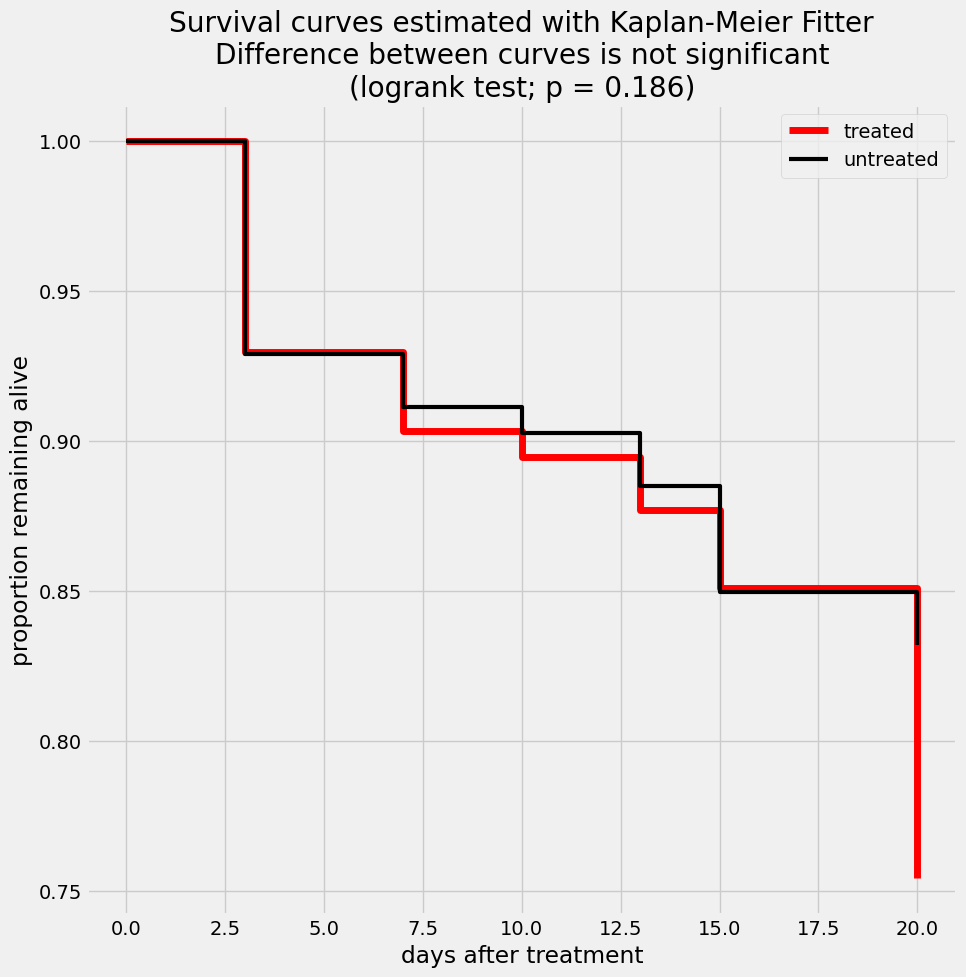

In [24]:
ax = plt.subplot()
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations=df[treated]['days_post_treatment'],
        event_observed=df[treated]['dead'], 
        label='treated')
kmf.plot(figsize=(8,8), ax=ax, ci_show=False, color='red', linewidth=5)

kmf.fit(durations=df[untreated]['days_post_treatment'], 
        event_observed=df[untreated]['dead'], 
        label='untreated')
kmf.plot(figsize=(10,10), ax=ax, ci_show=False, color='black', linewidth=3)

plt.title(f'Survival curves estimated with Kaplan-Meier Fitter\n{stats_result}')
plt.xlabel('days after treatment')
plt.ylabel('proportion remaining alive')
plt.savefig('results.png')
plt.show();